# Galaxy Collisions

### Importing modules and packages

In [16]:
import astropy.units as unit
from astropy.constants import G

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np

### Creating a dictionary by using the parameters of the galaxy

Mass -> Solar Mass (= $2 \times 10^{30}$ Kg) <br>
Radius -> Kiloparsec (= $3.086 \times 10^{19}$ m) <br>
Centre Position -> Kiloparsec (= $3.086 \times 10^{19}$ m) <br>
Centre Velocity -> Km/s <br>
Normal Vector of the galactic plane <br>
Number of rings in the galaxy <br>
Number of stars in the galaxy <br>
Softening Factor which defines inner edge of the disc

In [17]:
def create_galaxy(*args):
    if len(args) != 8:
        return("8 parameters are required")
        
    if len(args[2]) == 3 and len(args[3]) == 3 and len(args[4]) == 3:
        try:
            return {
                "mass" : args[0] * unit.M_sun,
                "radius" : args[1] * unit.kpc,
                "centre_position" : args[2] * unit.kpc,
                "centre_velocity" : args[3] * unit.km / unit.s,
                "normal_vector" : args[4],
                "rings" : args[5],
                "stars" : args[6],
                "softening_factor" : args[7] 
            }
        except:
            return("You have entered an invalid data type")
    else:
        return("Centre Position, Centre Velocity and Normal Vector must be a 3 tuple or triplet")

### Adding parameters stars position and stars velocity

Since we are following the Schroeder and Comin's model we will treat a galaxy as a disk with the same parameters.

We will assume that all the mass of the galaxy is concentrated in the center and that gravitational interactions between the stars around the center are negligible. There is no dark matter, no interstellar gas and dust, and stars only experience the gravity of the central mass or masses when dealing with a system of two galaxies.

The disk can be subdivided into '$x$' number of rings where each ring has a radial width '$dr$'. This width is calculated from the galaxy '$radius$' and the '$softening\_factor$' which is a fractional value which is used to avoid a boundless potential near the centre when computing the orbit of the stars.

In the next step we transfer the polar coordinates of the stars in the disk to a three-dimensional Cartesian coordinate system which we will refer to as the observer’s frame in which the disk can have arbitrary orientation. The orientation is defined by the normal vector $n = (nx , ny , nz)$ of the galactic plane which is defined as a 3-tuple '$normal\_vector$' in the galaxy’s dictionary and the disks normal is given by $n$' $= (0, 0, 1)$. To ensure that '$n$' is a unit vector the '$normal\_vector$' is divided by its length.

The rotational axis can thus be computed as the cross product of $n$ and $n$'. If the normal vectors $n$ and $n$' are aligned, the rotation angle is 0 and the rotation matrix is set equal to the identity matrix. The coordinates of a star are thus obtained from the rotation matrix '$rotation$' which is computed using Rodrigues' rotation formulae.

The velocity of the stars are computed through a similar procedure as the one performed in finding their coordinates.

Stars Position -> Kiloparsec (= $3.086 \times 10^{19}$ m) <br>
Stars Velocity -> Km/s <br>

### Formulae's used

- <font size = 3> $ R + r = 1 $ (Defined according to the model for a single ring)
- Normal $ (n) = \sqrt {x^2 + y^2 + z^2} $
- $ cos\theta = \Large \frac {n_z} {n} $
- $ sin^2\theta + cos^2\theta = 1 $
- Rotation Axis $ (u) = \Large \frac {n' \times n} {|n' \times n|} $
- Rotation Matrix $ = \begin{bmatrix} u^2_x (1 - cos\theta) + cos\theta & \ u_x u_y (1 - cos\theta) - u_z sin\theta & \ u_x u_z (1 - cos\theta) + u_y sin\theta \\ u_y u_x (1 - cos\theta) + u_z sin\theta & \ u^2_y (1 - cos\theta) + cos\theta & \ u_y u_z (1 - cos\theta) - u_x sin\theta \\ u_z u_x (1 - cos\theta) - u_y sin\theta & \ u_z u_y (1 - cos\theta) + u_x sin\theta & \ u^2_z (1 - cos\theta) + cos\theta \end{bmatrix} $
- $ \phi = tan^{-1} \Large (\frac {n_y} {n_x} ) $
- $ \theta = cos^{-1}(cos\theta) $
- Time Period of Circular Orbit $ (T) =  2\pi \sqrt {\Large \frac {r^3} {GM}} $
- $ \phi = 2\pi \Large \frac {\Delta t} {T} $
- Velocity Component $ (v_x) = \Large \frac {r[cos\phi - cos(\phi - \Delta\phi)]} {\Delta t} $
- Velocity Component $ (v_y) = \Large \frac {r[sin\phi - sin(\phi - \Delta\phi)]} {\Delta t} $
- Velocity Component $ (v_z) = 0 $
- Escape Velocity $ = \sqrt {\Large \frac {2GM} {R}}$
</font>

In [18]:
def add_parameters(galaxy, time_step = 0.1 * unit.Myr):
    # width of a ring
    dr = (1 - galaxy['softening_factor']) * galaxy['radius'] / galaxy['rings']
    stars_per_ring = int(galaxy['stars'] / galaxy['rings'])

    # rotation angle and axis(u)
    norm = np.sqrt(galaxy['normal_vector'][0] ** 2 + galaxy['normal_vector'][1] ** 2 + galaxy['normal_vector'][2] ** 2)
    cos_theta = galaxy['normal_vector'][2] / norm
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    u = np.cross([0, 0, 1], galaxy['normal_vector'] / norm)
    norm = np.sqrt(u[0] ** 2 + u[1] ** 2 + u[2] ** 2)

    if norm > 0:
        # unit vector
        u /= norm

        # rotation matrix for coordinate transformation
        # from galactic plane to observer's frame
        rotation = [
            [u[0] * u[0] * (1 - cos_theta) + cos_theta,
            u[0] * u[1] * (1 - cos_theta) - u[2] * sin_theta,
            u[0] * u[2] * (1 - cos_theta) + u[1] * sin_theta],

            [u[1] * u[0] * (1 - cos_theta) + u[2] * sin_theta,
            u[1] * u[1] * (1 - cos_theta) + cos_theta,
            u[1] * u[2] * (1 - cos_theta) - u[0] * sin_theta],

            [u[2] * u[0] * (1 - cos_theta) - u[1] * sin_theta,
            u[2] * u[1] * (1 - cos_theta) + u[0] * sin_theta,
            u[2] * u[2] * (1 - cos_theta) + cos_theta]
        ]

        # print angles defining orientation of galaxy
        phi = np.arctan2(galaxy['normal_vector'][1], galaxy['normal_vector'][0])
        theta = np.arccos(cos_theta)
        print("Plane normal: phi = {:.1f}°, theta = {:.1f}°".format(np.degrees(phi), np.degrees(theta)))

    else:
        rotation = np.identity(3)

    galaxy['stars_position'] = np.array([])
    galaxy['stars_velocity'] = np.array([])

    # begin with innermost radius given by softening factor
    R = galaxy['softening_factor'] * galaxy['radius']

    for _ in range(galaxy['rings']):
        # radial and angular coordinates in center-of-mass frame
        r_star = R + dr * np.random.random_sample(size = stars_per_ring)
        phi_star = 2 * np.pi * np.random.random_sample(size = stars_per_ring)

        # Cartesian coordinates in observer's frame
        vec_r = np.dot(rotation, r_star * [np.cos(phi_star), np.sin(phi_star), np.zeros(stars_per_ring)])

        x = galaxy['centre_position'][0] + vec_r[0]
        y = galaxy['centre_position'][1] + vec_r[1]
        z = galaxy['centre_position'][2] + vec_r[2]

        # orbital periods and angular displacements over one timestep
        T_star = 2 * np.pi * ((G * galaxy['mass']) ** (-1 / 2) * r_star ** (3 / 2)).to(unit.s)
        delta_phi = 2 * np.pi * time_step.to(unit.s).value / T_star.value

        # velocity components in observer's frame half a step in advance
        # (Leapfrog scheme)
        vec_v = np.dot(
            rotation,
            (r_star.to(unit.km) / time_step.to(unit.s)) * [(np.cos(phi_star) - np.cos(phi_star - delta_phi)),
            (np.sin(phi_star) - np.sin(phi_star - delta_phi)),
            np.zeros(stars_per_ring)]
        )
        
        v_x = galaxy['centre_velocity'][0] + vec_v[0]
        v_y = galaxy['centre_velocity'][1] + vec_v[1]
        v_z = galaxy['centre_velocity'][2] + vec_v[2]

        if galaxy['stars_position'].size == 0:
            galaxy['stars_position'] = np.array([x, y, z])
            galaxy['stars_velocity'] = np.array([v_x, v_y, v_z])
        else:
            galaxy['stars_position'] = np.append(galaxy['stars_position'], np.array([x, y, z]), axis = 1)
            galaxy['stars_velocity'] = np.append(galaxy['stars_velocity'], np.array([v_x ,v_y, v_z]), axis = 1)

        R += dr

    # units get lost through np.array
    galaxy['stars_position'] *= unit.kpc
    galaxy['stars_velocity'] *= unit.km / unit.s

    # typical velocity scale defined by Kepler velocity at half the disk radius
    galaxy['velocity_scale'] = np.sqrt(G * galaxy['mass'] / (0.5 * R)).to(unit.km / unit.s)

### Time evolution of an isolated disc(galaxy)

Before proceeding we convert all the data in the dictionaries to simple float values in SI units. This has been done to improve efficiency of the computation and so that we have flexibility of using arbitrary units in the input and output of the function.

The goal is to calculate the positions of the nuclei and stars through a number of time steps separated by a time interval using Leapfrog integration which is a method for numerically integrating differential equations. We use leapfrog integration because it is a second-order method, is computationally less expensive and since it is time reversible it respects the principle of conservation of energy. This allows us to simulate how the galaxy and its parameters change with respect to time. Leapfrog integration is equivalent to updating positions $x(t)$ and velocities $v(t)$ at interleaved time points, staggered in such a way that they "leapfrog" over each other. Based on this definition we can say that Leapfrog integration advances $x_i$ to $x_{i+1}$ and $v_{i + \frac{1}{2}}$ to $v_{i + \frac{3}{2}}$.

### Formulae's used

- <font size = 3> Radial Distance $ (R) = \sqrt {(X - x)^2 + (Y - y)^2 + (Z - z)^2} $
- Gravitational Acceleration $ = \Large \frac {GMr} {R^3} $
</font>

In [19]:
def time_evolution_disk(galaxy, time_step = 0.1 * unit.Myr, N_steps = 1000, N_snapshots = 100):
    dt = time_step.to(unit.s).value
    r_min = galaxy['softening_factor'] * galaxy['radius'].to(unit.m).value
    stars = galaxy['stars']

    # mass, position and velocity of galactic center
    M = galaxy['mass'].to(unit.kg).value
    X, Y, Z = galaxy['centre_position'].to(unit.m).value
    V_x, V_y, V_z = galaxy['centre_velocity'].to(unit.m / unit.s).value

    # initialize stellar coordintes
    x = galaxy['stars_position'][0].to(unit.m).value
    y = galaxy['stars_position'][1].to(unit.m).value
    z = galaxy['stars_position'][2].to(unit.m).value

    # intialize stellar velocities
    v_x = galaxy['stars_velocity'][0].to(unit.m / unit.s).value
    v_y = galaxy['stars_velocity'][1].to(unit.m / unit.s).value
    v_z = galaxy['stars_velocity'][2].to(unit.m / unit.s).value

    # array to store snapshots of all positions (centers and stars)
    snapshots = np.zeros(shape = (N_snapshots + 1, 3, stars + 1))
    snapshots[0] = [np.append([X], x), np.append([Y], y), np.append([Z], z)]
    #print(snapshots.shape)

    # number of steps per snapshot
    div = max(int(N_steps / N_snapshots), 1)

    print("Solving equations of motion for single galaxy (Leapfrog integration)")

    for n in range(1, N_steps + 1):

        # radial distances from center
        r = np.maximum(np.sqrt((X - x) ** 2 + (Y - y) ** 2 + (Z - z) ** 2), r_min)

        # update velocities of stars (acceleration due to gravity of center)
        v_x += G.value * M * ((X - x) / r ** 3) * dt
        v_y += G.value * M * ((Y - y) / r ** 3) * dt
        v_z += G.value * M * ((Z - z) / r ** 3) * dt

        # update positions of stars
        x += v_x * dt
        y += v_y * dt
        z += v_z * dt

        # update position of center
        X += V_x * dt
        Y += V_y * dt
        Z += V_z * dt

        if n % div == 0:
            i = int(n / div)
            snapshots[i] = [np.append([X], x), np.append([Y], y), np.append([Z], z)]

        # fraction of computation done
        print("\r{:3d} %".format(int(100 * n / N_steps)), end="")

    time = np.linspace(0 * time_step, N_steps * time_step, N_snapshots + 1, endpoint = True)
    print(" (stopped at t = {:.1f})".format(time[-1]))

    snapshots *= unit.m

    return time, snapshots.to(unit.kpc)

### Time evolution of a pair of discs(galaxies)

Before proceeding we convert all the data in the dictionaries to simple float values in SI units. This has been done to improve efficiency of the computation and so that we have flexibility of using arbitrary units in the input and output of the function.

The positions of stars in both disks are joined into arrays $x$, $y$, and $z$. As a result, the length of the three coordinate arrays equals the total number of stars in the primary and secondary disks. This allows us to apply operations at once to all stars.

The goal is to calculate the positions of the nuclei and stars through a number of time steps separated by a time interval using Leapfrog integration which is a method for numerically integrating differential equations. We use leapfrog integration because it is a second-order method, is computationally less expensive and since it is time reversible it respects the principle of conservation of energy. This allows us to simulate how the galaxy and its parameters change with respect to time. Leapfrog integration is equivalent to updating positions $x(t)$ and velocities $v(t)$ at interleaved time points, staggered in such a way that they "leapfrog" over each other. Based on this definition we can say that Leapfrog integration advances $x_i$ to $x_{i+1}$ and $v_{i + \frac{1}{2}}$ to $v_{i + \frac{3}{2}}$.

### Formulae's used

- <font size = 3> Radial Distance $ (R) = \sqrt {(X - x)^2 + (Y - y)^2 + (Z - z)^2} $
- Gravitational Acceleration $ = \Large \frac {GMr} {R^3} $
</font>

In [20]:
def time_evolution_two_disks(primary, secondary, time_step = 0.1 * unit.Myr, N_steps = 1000, N_snapshots = 100):
    dt = time_step.to(unit.s).value

    r_min1 = primary['softening_factor'] * primary['radius'].to(unit.m).value
    r_min2 = secondary['softening_factor'] * secondary['radius'].to(unit.m).value

    N1, N2 = primary['stars'], secondary['stars']

    # mass, position and velocity of primary galactic center
    M1 = primary['mass'].to(unit.kg).value
    X1, Y1, Z1 = primary['centre_position'].to(unit.m).value
    V1_x, V1_y, V1_z = primary['centre_velocity'].to(unit.m / unit.s).value

    # mass, position and velocity of secondary galactic center
    M2 = secondary['mass'].to(unit.kg).value
    X2, Y2, Z2 = secondary['centre_position'].to(unit.m).value
    V2_x, V2_y, V2_z = secondary['centre_velocity'].to(unit.m / unit.s).value

    # stellar coordinates of primary
    x = primary['stars_position'][0].to(unit.m).value
    y = primary['stars_position'][1].to(unit.m).value
    z = primary['stars_position'][2].to(unit.m).value

    # stellar coordinates of secondary
    x = np.append(x, secondary['stars_position'][0].to(unit.m).value)
    y = np.append(y, secondary['stars_position'][1].to(unit.m).value)
    z = np.append(z, secondary['stars_position'][2].to(unit.m).value)

    # stellar velocities of primary
    v_x = primary['stars_velocity'][0].to(unit.m / unit.s).value
    v_y = primary['stars_velocity'][1].to(unit.m / unit.s).value
    v_z = primary['stars_velocity'][2].to(unit.m / unit.s).value

    # stellar velocities of secondary
    v_x = np.append(v_x, secondary['stars_velocity'][0].to(unit.m / unit.s).value)
    v_y = np.append(v_y, secondary['stars_velocity'][1].to(unit.m / unit.s).value)
    v_z = np.append(v_z, secondary['stars_velocity'][2].to(unit.m / unit.s).value)

    # array to store snapshots of all positions (centres and stars)
    snapshots = np.zeros(shape = (N_snapshots + 1, 3, N1 + N2 + 2))
    snapshots[0] = [np.append([X1, X2], x), np.append([Y1, Y2], y), np.append([Z1, Z2], z)]
    #print(snapshots.shape)

    # number of steps per snapshot
    div = max(int(N_steps / N_snapshots), 1)

    print("Solving equations of motion for two galaxies (Leapfrog integration)")

    for n in range(1, N_steps + 1):

        # radial distances from centers with softening_factor
        r1 = np.maximum(np.sqrt((X1 - x) ** 2 + (Y1 - y) ** 2 + (Z1 - z) ** 2), r_min1)
        r2 = np.maximum(np.sqrt((X2 - x) ** 2 + (Y2 - y) ** 2 + (Z2 - z) ** 2), r_min2)
        #print("\nr {:.6e} {:.6e} {:.6e} {:.6e}".format(r1[0],r2[0],r1[N1],r2[N1]))

        # update velocities of stars (acceleration due to gravity of centers)
        v_x += G.value * (M1 * (X1 - x) / r1 ** 3 + M2 * (X2 - x) / r2 ** 3) * dt
        v_y += G.value * (M1 * (Y1 - y) / r1 ** 3 + M2 * (Y2 - y) / r2 ** 3) * dt
        v_z += G.value * (M1 * (Z1 - z) / r1 ** 3 + M2 * (Z2 - z) / r2 ** 3) * dt
        #print("v_x {:.1f} {:.1f}".format(v_x[0],v_x[N1]))

        # update positions of stars
        x += v_x * dt
        y += v_y * dt
        z += v_z * dt
        #print("x {:.6e} {:.6e}".format(x[0],x[N1]))

        # distance between centers
        D_sqr_min = (r_min1 + r_min2) ** 2
        D_cubed = (max((X1 - X2) ** 2 + (Y1 - Y2) ** 2 + (Z1 - Z2) ** 2, D_sqr_min)) ** (3 / 2)

        # gravitational acceleration of primary center
        A1_x = G.value * M2 * (X2 - X1) / D_cubed
        A1_y = G.value * M2 * (Y2 - Y1) / D_cubed
        A1_z = G.value * M2 * (Z2 - Z1) / D_cubed

        # update velocities of centers (constant center-of-mass velocity)
        V1_x += A1_x * dt; V2_x -= (M1 / M2) * A1_x * dt
        V1_y += A1_y * dt; V2_y -= (M1 / M2) * A1_y * dt
        V1_z += A1_z * dt; V2_z -= (M1 / M2) * A1_z * dt
        #print("V {:.1f} {:.1f} {:.1f}".format(V1_x,V2_x,(M1*V1_x+M2*V2_x)/(M1+M2)))

        # update positions of centers
        X1 += V1_x * dt; X2 += V2_x * dt
        Y1 += V1_y * dt; Y2 += V2_y * dt
        Z1 += V1_z * dt; Z2 += V2_z * dt
        #print("X {:.6e} {:.6e} {:.6e}".format(X1,X2,X1+X2))

        if n % div == 0:
            i = int(n / div)
            snapshots[i] = [np.append([X1, X2], x), np.append([Y1, Y2], y), np.append([Z1, Z2], z)]

        # fraction of computation done
        print("\r{:3d} %".format(int(100 * n / N_steps)), end="")

    time = np.linspace(0, N_steps * time_step, N_snapshots + 1, endpoint = True)
    print(" (stopped at t = {:.1f})".format(time[-1]))

    snapshots *= unit.m

    return time, snapshots.to(unit.kpc)

### Animating single disc in XY Plane (2D)

In [21]:
def anim_disk_2d(data, xlim, ylim, time = None, name = 'anim_disk_2D'):
    aspect_ratio = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])
    fig, ax = plt.subplots(figsize = (10, 1.0 + 10 * aspect_ratio), dpi = 150)
    
    ax.set_aspect('equal')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)

    sct = ax.scatter(data[0, 0, :], data[0, 1, :], s = 2, marker = '.', color = 'blue')

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time[0]))

    def update(i):
        sct.set_offsets(np.c_[data[i, 0, :], data[i, 1, :]])

        if time != None:
            title.set_text('$t$ = {:.1f}'.format(time[i]))
        
        return sct,

    anim = FuncAnimation(fig, update, frames = len(data), interval = 15, blit = True, repeat = False)
    anim.save(name + '.mp4')

### Plotting stars for a single snapshot of an isolated disc

In [22]:
def show_disk_3d(snapshot, xlim = None, ylim = None, zlim = None, time = None):
    fig = plt.figure(figsize =(10, 10), dpi = 150)
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)
    ax.set_zlabel(r'$z$ [kpc]', fontsize = 12)

    if xlim != None: ax.set_xlim(xlim[0], xlim[1])
    if ylim != None: ax.set_ylim(ylim[0], ylim[1])
    if zlim != None: ax.set_zlim(zlim[0], zlim[1])

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time))

    ax.scatter(snapshot[0, 1:], snapshot[1, 1:], snapshot[2, 1:], marker = '.', color = 'blue', s = 2)

### Animating isolated disk system in 3D

In [23]:
def anim_disk_3d(data, xlim = None, ylim = None, zlim = None, time = None, name = 'anim_disk_3D'):
    fig = plt.figure(figsize = (10, 10), dpi = 150)
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)
    ax.set_zlabel(r'$z$ [kpc]', fontsize = 12)

    if xlim != None: ax.set_xlim(xlim[0], xlim[1])
    if ylim != None: ax.set_ylim(ylim[0], ylim[1])
    if zlim != None: ax.set_zlim(zlim[0], zlim[1])

    sct = ax.scatter(data[0, 0, 1:], data[0, 1, 1:], data[0, 2, 1:], s = 2, marker = '.', color = 'blue')

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time[0]))

    def update(i):
        sct._offsets3d = (data[i, 0, 1:], data[i, 1, 1:], data[i, 2, 1:])

        if time != None:
            title.set_text('$t$ = {:.1f}'.format(time[i]))
        
        return sct,

    anim = FuncAnimation(fig, update, frames = len(data), interval = 15, blit = True, repeat = False)
    anim.save(name+'.mp4')

### Plotting centres and stars for a single snapshot of 2 discs

In [24]:
def show_two_disks_2d(snapshot, N1, xlim, ylim, time = None):
    N2 = snapshot.shape[1] - 2 - N1
    aspect_ratio = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

    fig, ax = plt.subplots(figsize = (10, 1.0 + 10 * aspect_ratio), dpi = 100)

    ax.set_aspect('equal')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time))

    ax.scatter(snapshot[0, 0:2], snapshot[1, 0:2], marker = '+', color = 'black')
    ax.scatter(snapshot[0, 2:N1 + 2], snapshot[1, 2:N1 + 2], s = 2, marker = '.', color = 'blue')
    ax.scatter(snapshot[0, N1 + 2:N1 + N2 + 2], snapshot[1, N1 + 2:N1 + N2 + 2], s = 2, marker = '.', color = 'red')

### Animating 2 disc system in XY Plane (2D)

In [25]:
def anim_two_disks_2d(data, N1, xlim, ylim, time = None, name = 'anim_two_disks_2D'):
    N2 = data.shape[2] - 2 - N1
    aspect_ratio = (ylim[1] - ylim[0]) / (xlim[1] - xlim[0])

    fig, ax = plt.subplots(figsize = (10, 1.0 + 10 * aspect_ratio), dpi = 150)

    ax.set_aspect('equal')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)

    sct = ax.scatter(data[0, 0, 0:2], data[0, 1, 0:2], marker = '+', color = 'black')
    sct1 = ax.scatter(data[0, 0, 2:N1 + 2], data[0, 1, 2:N1 + 2], marker = '.', color = 'blue', s = 2)
    sct2 = ax.scatter(data[0, 0, N1 + 2:N1 + N2 + 2], data[0, 1, N1 + 2:N1 + N2 + 2], marker = '.', color = 'red', s = 2)

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time[0]))

    def update(i):
        sct.set_offsets(np.c_[data[i, 0, 0:2], data[i, 1, 0:2]])
        sct1.set_offsets(np.c_[data[i, 0, 2:N1 + 2], data[i, 1, 2:N1 + 2]])
        sct2.set_offsets(np.c_[data[i, 0, N1 + 2:N1 + N2 + 2], data[i, 1, N1 + 2:N1 + N2 + 2]])

        if time != None:
            title.set_text('$t$ = {:.1f}'.format(time[i]))

        return sct, sct1, sct2,

    anim = FuncAnimation(fig, update, frames = len(data), interval = 15, blit = True, repeat = False)
    anim.save(name + '.mp4')

### Plotting centres and stars for a single snapshot of 2 discs in 3D

In [26]:
def show_two_disks_3d(snapshot, N1, xlim = None, ylim = None, zlim = None, time = None):
    N2 = snapshot.shape[1] - 2 - N1

    fig = plt.figure(figsize = (10, 10), dpi = 150)
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)
    ax.set_zlabel(r'$z$ [kpc]', fontsize = 12)

    if xlim != None: ax.set_xlim(xlim[0], xlim[1])
    if ylim != None: ax.set_ylim(ylim[0], ylim[1])
    if zlim != None: ax.set_zlim(zlim[0], zlim[1])

    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time))

    ax.scatter(snapshot[0, 0:2], snapshot[1, 0:2], snapshot[2, 0:2], marker = '+', color = 'black')
    ax.scatter(snapshot[0, 2:N1 + 2], snapshot[1, 2:N1 + 2], snapshot[2, 2:N1 + 2], marker = '.', color = 'blue', s = 2)
    ax.scatter(snapshot[0,N1 + 2:N1 + N2 + 2], snapshot[1, N1 + 2:N1 + N2 + 2], snapshot[2, N1 + 2:N1 + N2 + 2], marker = '.', color = 'red', s = 2)

### Animating 2 disc system in 3D

In [27]:
def anim_two_disks_3d(data, N1, xlim = None, ylim = None, zlim = None, time = None, name = 'anim_two_disks_3D'):
    N2 = data.shape[2] - 2 - N1

    fig = plt.figure(figsize = (10, 10), dpi = 150)
    ax = fig.add_subplot(111, projection = '3d')

    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r'$x$ [kpc]', fontsize = 12)
    ax.set_ylabel(r'$y$ [kpc]', fontsize = 12)
    ax.set_zlabel(r'$z$ [kpc]', fontsize = 12)

    if xlim != None: ax.set_xlim(xlim[0], xlim[1])
    if ylim != None: ax.set_ylim(ylim[0], ylim[1])
    if zlim != None: ax.set_zlim(zlim[0], zlim[1])

    sct  = ax.scatter(data[0, 0, 0:2], data[0, 1, 0:2], data[0, 2, 0:2], marker = '+', color = 'black')
    sct1 = ax.scatter(data[0, 0, 2:N1 + 2], data[0, 1, 2:N1 + 2], data[0, 2, 2:N1 + 2], marker = '.', color = 'blue', s = 2)
    sct2 = ax.scatter(data[0, 0, N1 + 2:N1 + N2 + 2], data[0, 1, N1 + 2:N1 + N2 + 2], data[0, 2, N1 + 2:N1 + N2 + 2], marker = '.', color = 'red', s = 2)
    
    if time != None:
        title = ax.set_title('$t$ = {:.1f}'.format(time[0]))

    def update(i):
        sct._offsets3d = (data[i, 0, 0:2], data[i, 1, 0:2], data[i, 2, 0:2])
        sct1._offsets3d = (data[i, 0, 2:N1 + 2], data[i, 1, 2:N1 + 2], data[i, 2, 2:N1 + 2])
        sct2._offsets3d = (data[i, 0, N1 + 2:N1 + N2 + 2], data[i, 1, N1 + 2:N1 + N2 + 2], data[i, 2, N1 + 2:N1 + N2 + 2])

        if time != None:
            title.set_text('$t$ = {:.1f}'.format(time[i]))
            
        return sct, sct1, sct2,

    anim = FuncAnimation(fig, update, frames = len(data), interval = 15, blit = True)
    anim.save(name + '.mp4')

### Test Case 1

This is an example for a nearly edge-on collision. A smaller intruder galaxy moves under an angle of 45° in the $xy$-plane with an impact velocity of about 130 km/s towards a larger, more massive target galaxy. The impact parameter is 6 kpc in $z$-direction.

In [28]:
galaxies = {
    'intruder' : create_galaxy(1e10, 5, (25, -25, -5), (-75, 75, 0), (0, 0, 1), 5, 1000, 0.025),
    'target' : create_galaxy(5e10, 10, (-5, 5, 1), (15, -15, 0), (1, -1, 2 ** 0.5), 10, 4000, 0.025),
}

In [29]:
galaxies['intruder']

{'mass': <Quantity 1.e+10 solMass>,
 'radius': <Quantity 5. kpc>,
 'centre_position': <Quantity [ 25., -25.,  -5.] kpc>,
 'centre_velocity': <Quantity [-75.,  75.,   0.] km / s>,
 'normal_vector': (0, 0, 1),
 'rings': 5,
 'stars': 1000,
 'softening_factor': 0.025}

In [30]:
galaxies['target']

{'mass': <Quantity 5.e+10 solMass>,
 'radius': <Quantity 10. kpc>,
 'centre_position': <Quantity [-5.,  5.,  1.] kpc>,
 'centre_velocity': <Quantity [ 15., -15.,   0.] km / s>,
 'normal_vector': (1, -1, 1.4142135623730951),
 'rings': 10,
 'stars': 4000,
 'softening_factor': 0.025}

In [31]:
add_parameters(galaxies['intruder'])
add_parameters(galaxies['target'])

Plane normal: phi = -45.0°, theta = 45.0°


In [32]:
galaxies['intruder']

{'mass': <Quantity 1.e+10 solMass>,
 'radius': <Quantity 5. kpc>,
 'centre_position': <Quantity [ 25., -25.,  -5.] kpc>,
 'centre_velocity': <Quantity [-75.,  75.,   0.] km / s>,
 'normal_vector': (0, 0, 1),
 'rings': 5,
 'stars': 1000,
 'softening_factor': 0.025,
 'stars_position': <Quantity [[ 24.05821135,  24.41337226,  24.87414265, ...,  20.74218753,
              28.63257293,  23.15352008],
            [-24.72211382, -24.66472441, -24.97459415, ..., -25.58514661,
             -23.01753807, -21.26539715],
            [ -5.        ,  -5.        ,  -5.        , ...,  -5.        ,
              -5.        ,  -5.        ]] kpc>,
 'stars_velocity': <Quantity [[-136.41091219, -204.34216778, -313.97843645, ...,
              -61.49816036, -123.72415315, -166.1362135 ],
            [-125.06902411, -141.60136381, -446.50884606, ...,
              -24.12049868,  164.54799273,   30.08135761],
            [   0.        ,    0.        ,    0.        , ...,
                0.        ,    0.     

In [33]:
galaxies['target']

{'mass': <Quantity 5.e+10 solMass>,
 'radius': <Quantity 10. kpc>,
 'centre_position': <Quantity [-5.,  5.,  1.] kpc>,
 'centre_velocity': <Quantity [ 15., -15.,   0.] km / s>,
 'normal_vector': (1, -1, 1.4142135623730951),
 'rings': 10,
 'stars': 4000,
 'softening_factor': 0.025,
 'stars_position': <Quantity [[ -5.37857036,  -4.63919478,  -4.86648293, ..., -13.40700111,
              -6.62606782,  -2.54316576],
            [  4.28896184,   5.66149589,   4.21077217, ...,   3.30483249,
              -3.15026483,  13.00651783],
            [  0.76490977,   1.21262041,   0.34752082, ...,   5.74598305,
              -3.61330394,   4.9242189 ]] kpc>,
 'stars_velocity': <Quantity [[ 381.9440766 , -360.7132246 ,  406.96690976, ...,
               -2.84392785,  142.67223067, -110.6549141 ],
            [-118.74879767,   99.69307314,  162.93883329, ...,
             -140.71119357,    3.20121011,  -18.59604411],
            [-332.83012325,  346.76961867, -151.34070423, ...,
              -76.273

In [34]:
t, data = time_evolution_two_disks(galaxies['target'], galaxies['intruder'], time_step = 0.05 * unit.Myr, N_steps=10000, N_snapshots=500)

Solving equations of motion for two galaxies (Leapfrog integration)
100 % (stopped at t = 500.0 Myr)


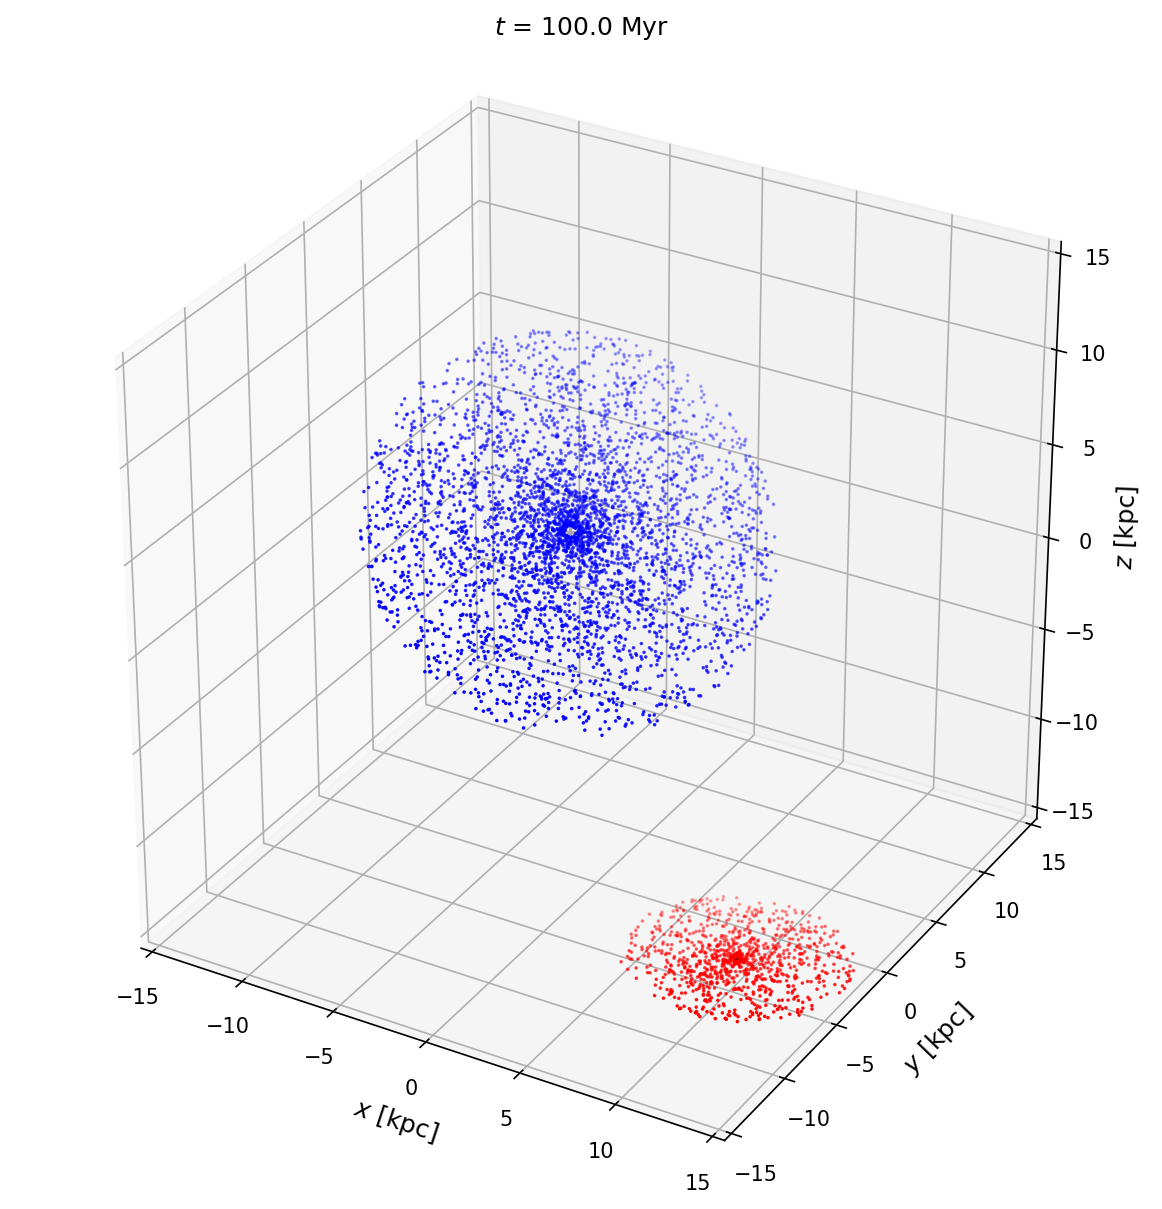

In [35]:
i = 100
show_two_disks_3d(data[i, :, :], galaxies['target']['stars'], [-15, 15], [-15, 15], [-15, 15], t[i])

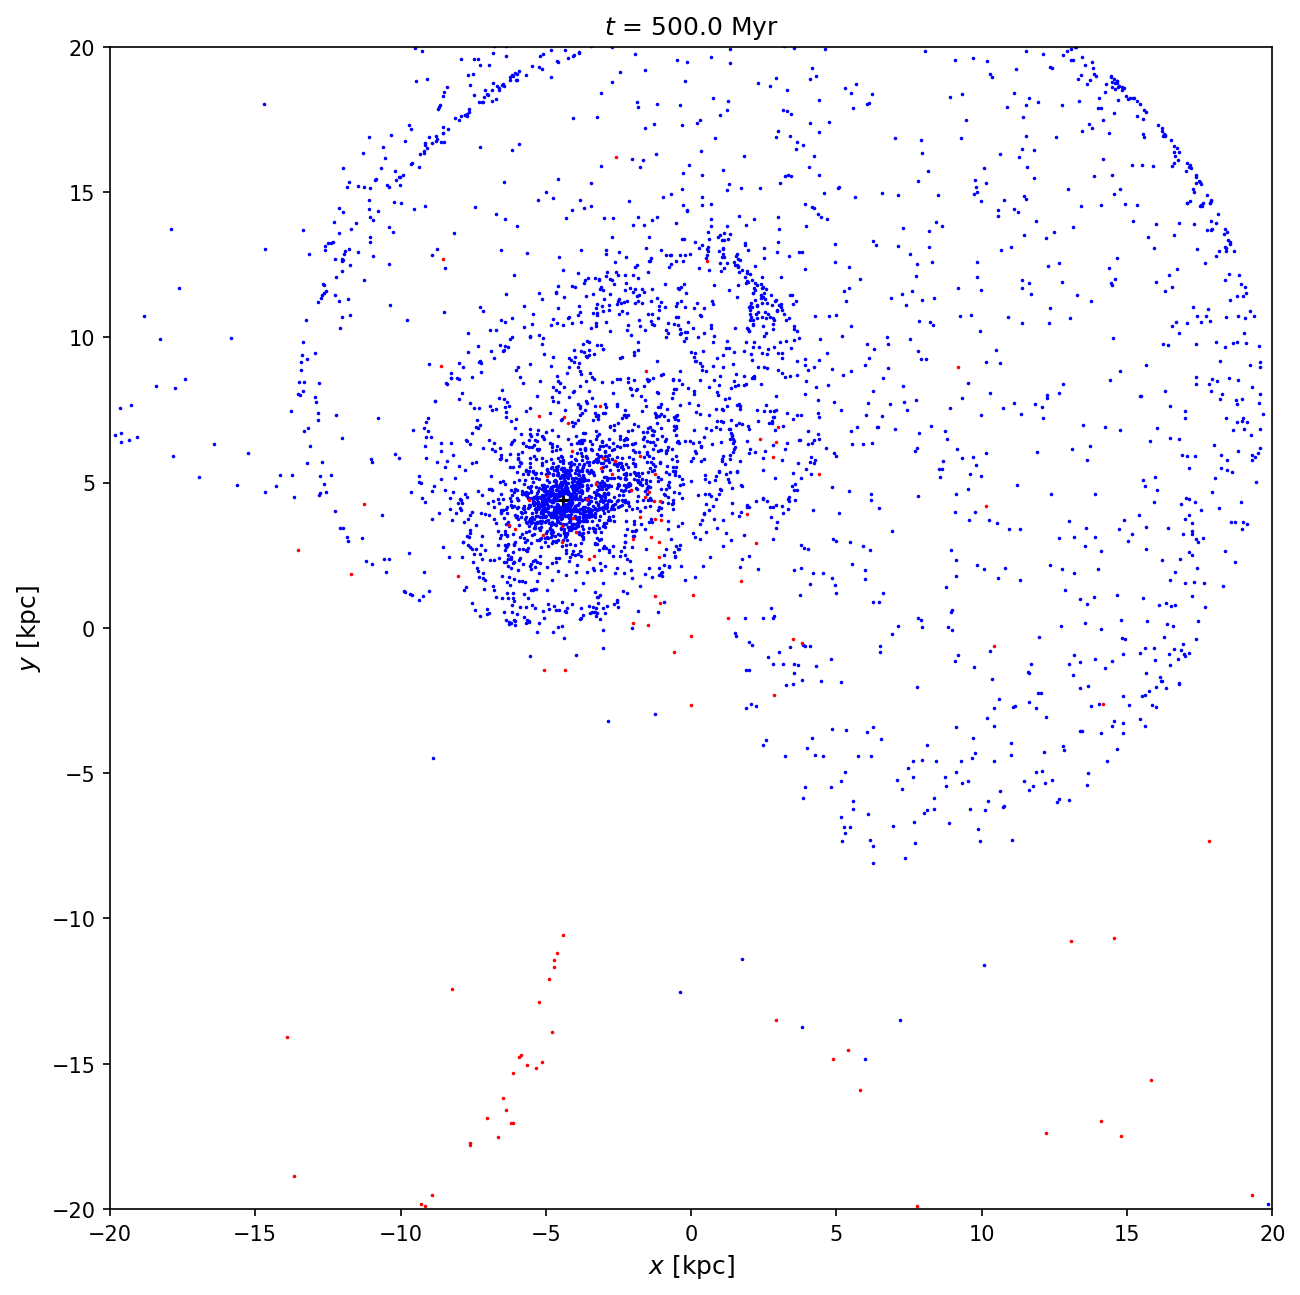

In [36]:
anim_two_disks_2d(data, galaxies['target']['stars'], [-20, 20], [-20, 20], t)

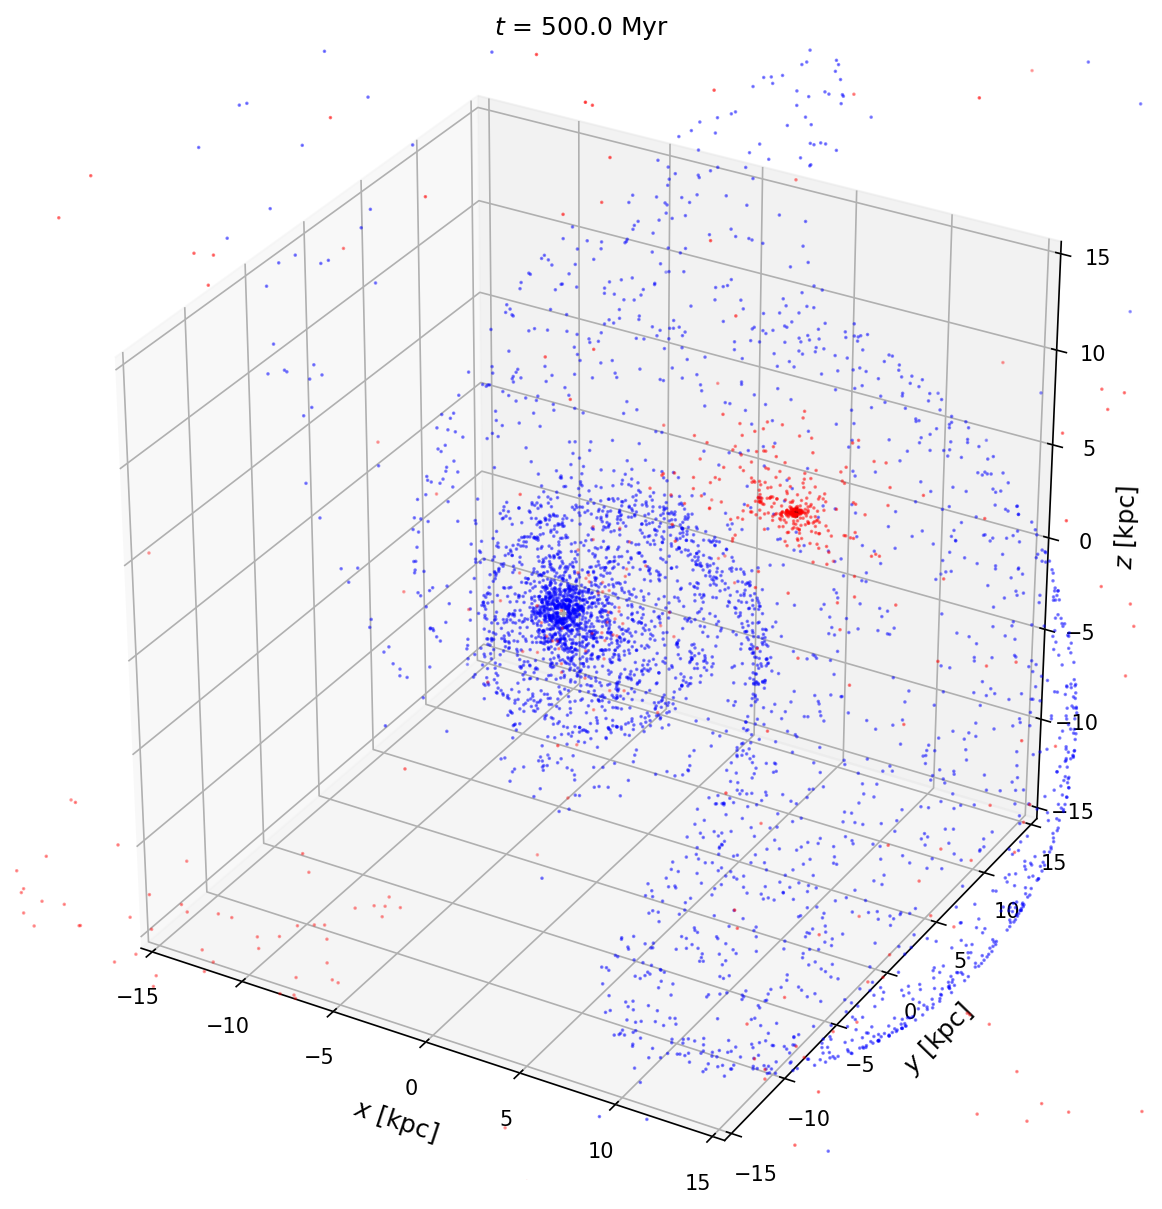

In [37]:
anim_two_disks_3d(data, galaxies['target']['stars'], [-15, 15], [-15, 15], [-15, 15], t)

### Test Case 2

Computing the time evolution of an isolated disc centered at (0, 0, 0).

In [38]:
galaxy = create_galaxy(5e10, 10, (0, 0, 0), (15, -15, 0), (1, -1, 2 ** 0.5), 10, 4000, 0.025)

In [39]:
add_parameters(galaxy)

Plane normal: phi = -45.0°, theta = 45.0°


In [40]:
galaxy

{'mass': <Quantity 5.e+10 solMass>,
 'radius': <Quantity 10. kpc>,
 'centre_position': <Quantity [0., 0., 0.] kpc>,
 'centre_velocity': <Quantity [ 15., -15.,   0.] km / s>,
 'normal_vector': (1, -1, 1.4142135623730951),
 'rings': 10,
 'stars': 4000,
 'softening_factor': 0.025,
 'stars_position': <Quantity [[-0.89365403,  0.66088981,  0.34670693, ...,  0.34426524,
              6.39270503, -3.89538001],
            [-0.06356879,  0.21465416,  0.30391464, ..., -7.27902574,
             -3.01460931,  5.21267888],
            [ 0.58695891, -0.31553625, -0.03025872, ..., -5.39048075,
             -6.65197576,  6.4403702 ]] kpc>,
 'stars_velocity': <Quantity [[ -96.93785982,   35.50303189, -240.26786141, ...,
              148.26906087,   98.77592024, -100.65926927],
            [-402.58896862,  424.73444053,  401.67834072, ...,
               34.82936849,  105.2957917 , -114.93658228],
            [-194.91476827,  296.44137194,  475.13771612, ...,
              -59.00077231,   25.82344876,

In [41]:
t, data = time_evolution_disk(galaxy, time_step = 0.05 * unit.Myr, N_steps = 10000, N_snapshots = 500)

Solving equations of motion for single galaxy (Leapfrog integration)
100 % (stopped at t = 500.0 Myr)


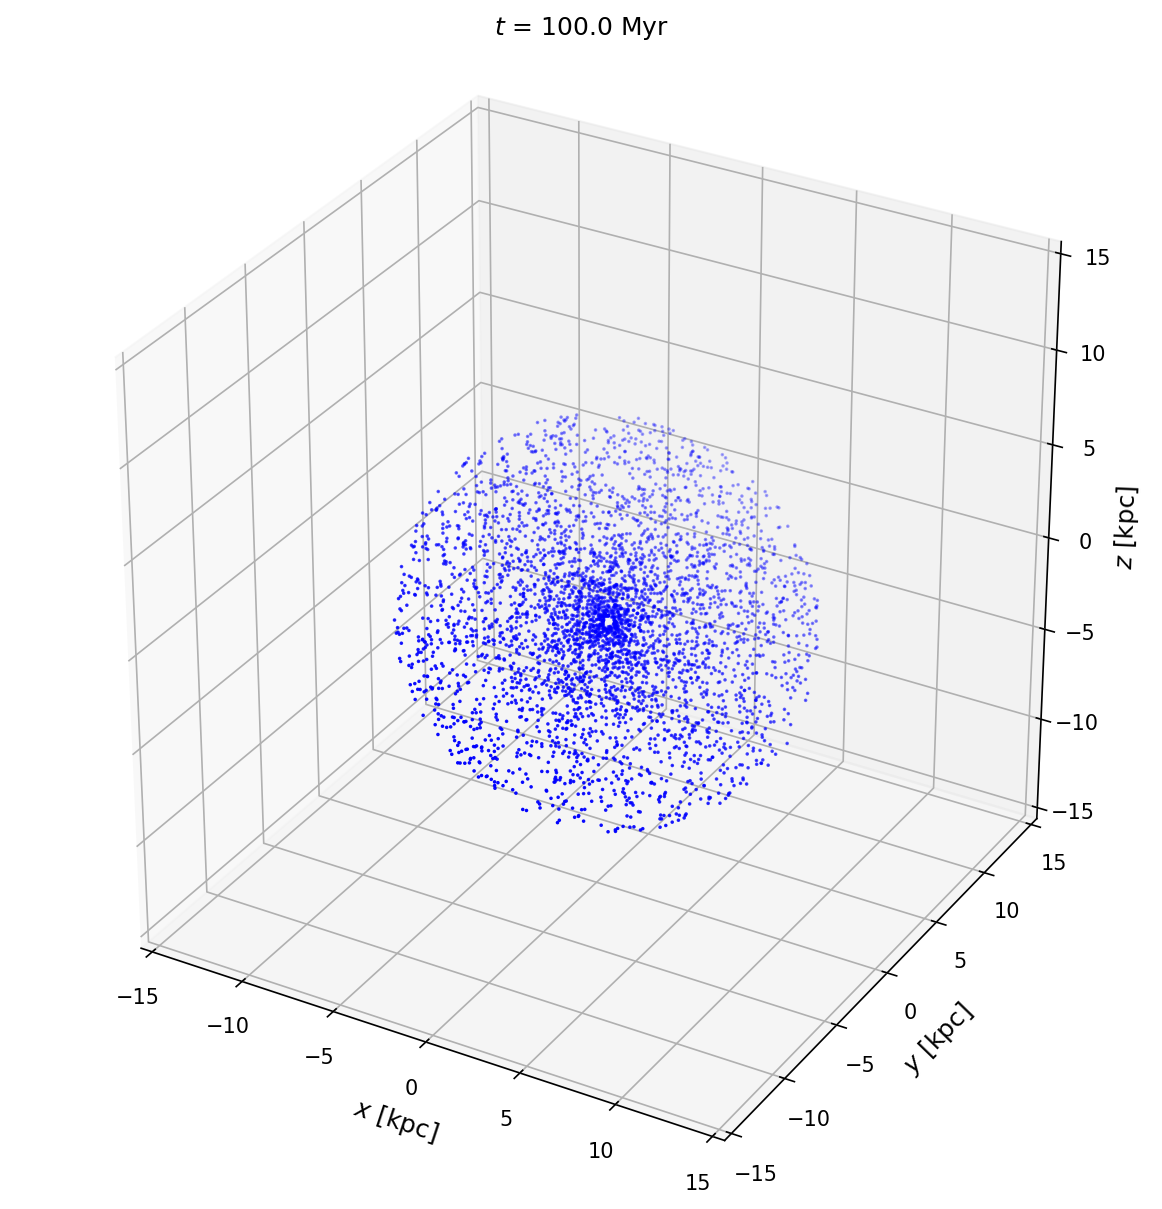

In [42]:
i = 100
show_disk_3d(data[i, :, :], [-15, 15], [-15, 15], [-15, 15], t[i])

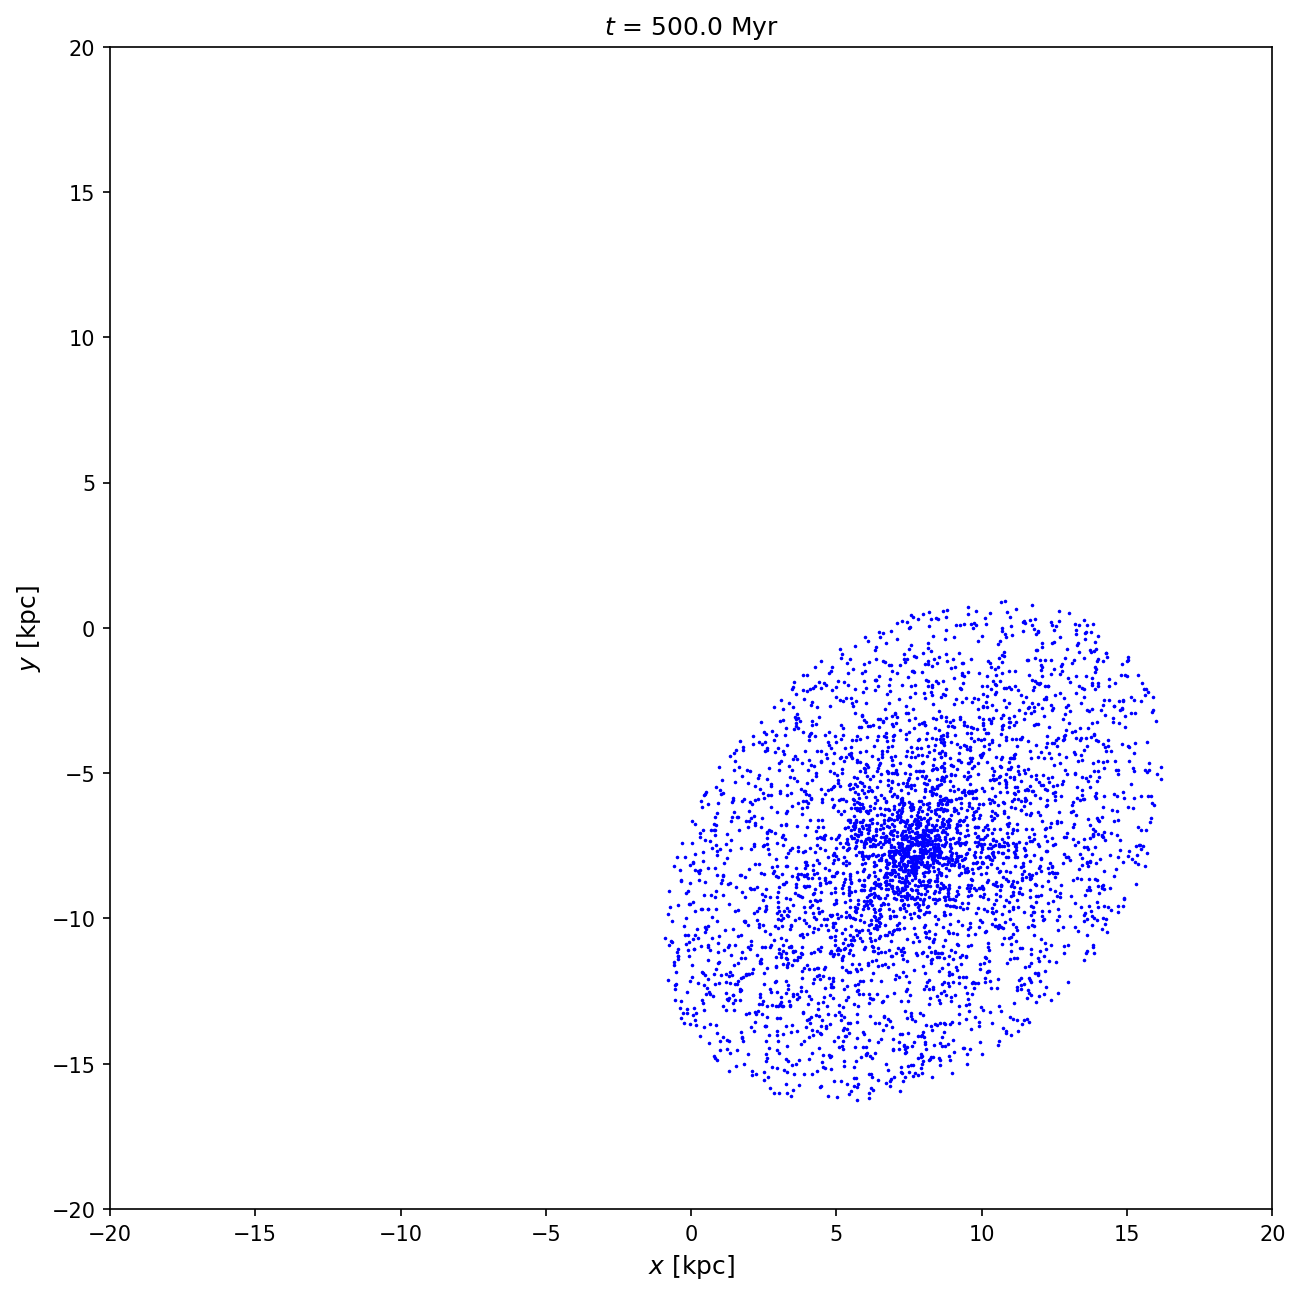

In [43]:
anim_disk_2d(data, [-20, 20], [-20, 20], t)

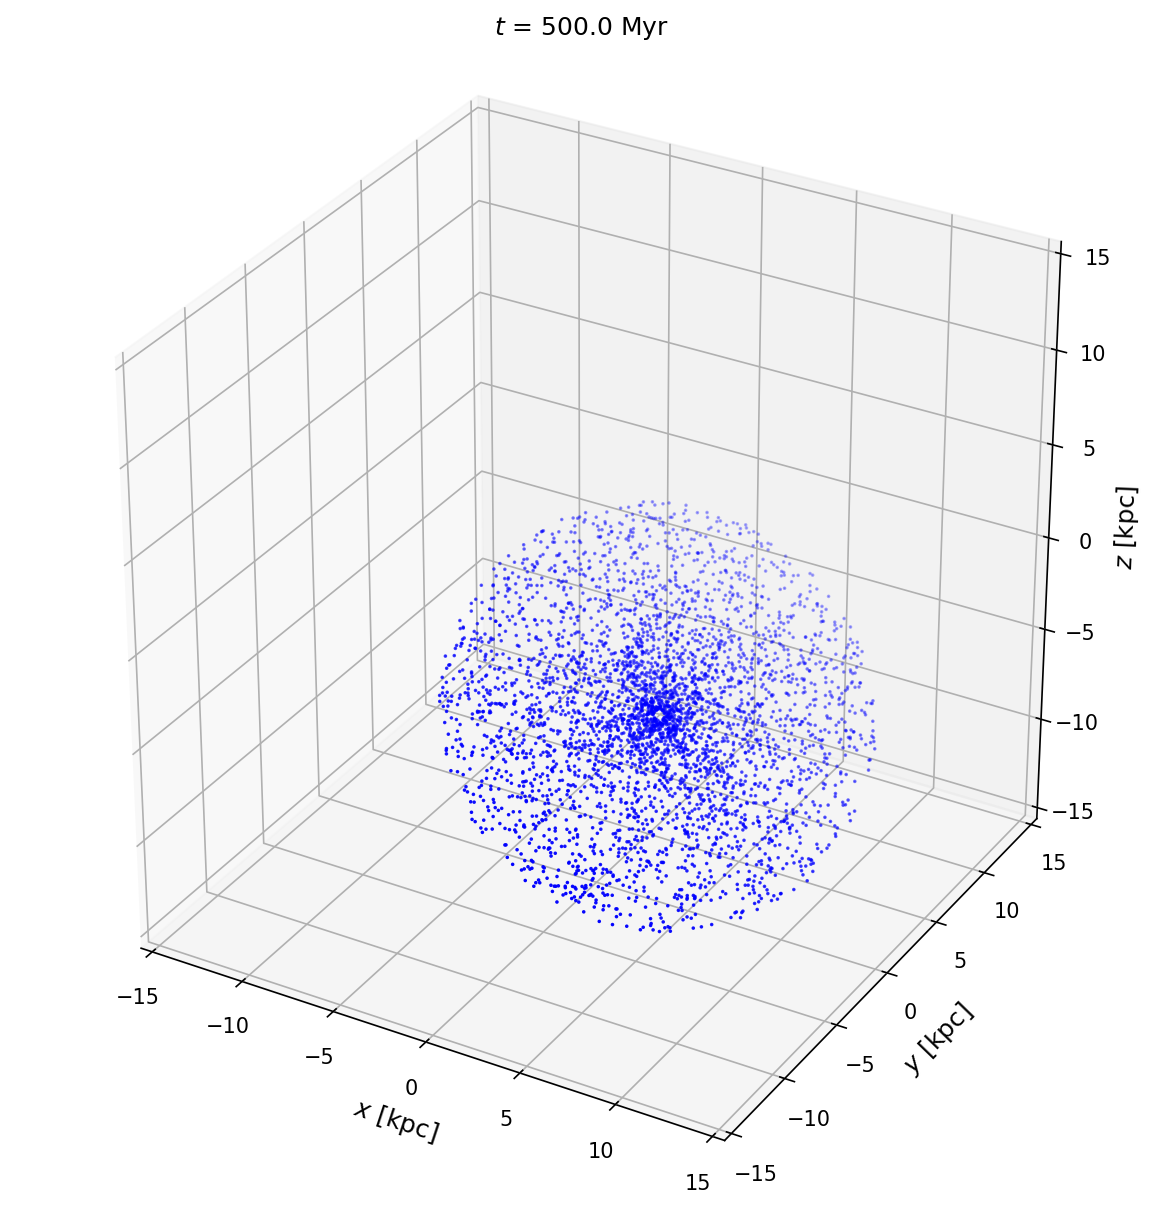

In [44]:
anim_disk_3d(data, [-15, 15], [-15, 15], [-15, 15], t)

### Flaws with the model

Although the underlying model is very simple and we are able to simulate the interactions between the galaxies accurately we have completely ignored dark matter, interstellar gases and dust. Due to this the model is unrealistic in some important aspects.

- <font size = 3> The collision of real galaxies is not governed by two-body dynamics. The dark matter halos with their embedded disks of baryonic matter can even merge into a single galaxy. It is believed that galaxies typically undergo several merges in the course of cosmic history.
- The ejection of stars through the slingshot effect, which is caused by strong acceleration during the close flyby of the gravitating center, is prone to numerical errors. To compute the trajectories more accurately a very low timestep would be required, which in turn would substantially increase the computing time.
</font>